In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt

import pickle
import numpy as np

import MDAnalysis as mda
import MDAnalysis.analysis.hole
import MDAnalysis.analysis.rms
from MDAnalysis.analysis.hole import HOLE, HOLEtraj


In [2]:
def regularized_function(x, y, func, bins=100, range=None):
    """Compute *func()* over data aggregated in bins.
    ``(x,y) --> (x', func(Y'))``  with ``Y' = {y: y(x) where x in x' bin}``
    First the data is collected in bins x' along x and then *func* is
    applied to all data points Y' that have been collected in the bin.
    .. function:: func(y) -> float
       *func* takes exactly one argument, a numpy 1D array *y* (the
       values in a single bin of the histogram), and reduces it to one
       scalar float.
    .. Note:: *x* and *y* must be 1D arrays.
    :Arguments:
       x
          abscissa values (for binning)
       y
          ordinate values (func is applied)
       func
          a numpy ufunc that takes one argument, func(Y')
       bins
          number or array
       range
          limits (used with number of bins)
    :Returns:
       F,edges
          function and edges (``midpoints = 0.5*(edges[:-1]+edges[1:])``)
    (This function originated as
    :func:`recsql.sqlfunctions.regularized_function`.)
    """
    _x = np.asarray(x)
    _y = np.asarray(y)

    if len(_x.shape) != 1 or len(_y.shape) != 1:
        raise TypeError("Can only deal with 1D arrays.")

    # setup of bins (taken from numpy.histogram)
    if (range is not None):
        mn, mx = range
        if (mn > mx):
            raise AttributeError('max must be larger than min in range parameter.')

    if not np.iterable(bins):
        if range is None:
            range = (_x.min(), _x.max())
        mn, mx = [float(mi) for mi in range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = np.linspace(mn, mx, bins+1, endpoint=True)
    else:
        bins = np.asarray(bins)
        if (np.diff(bins) < 0).any():
            raise ValueError('bins must increase monotonically.')

    sorting_index = np.argsort(_x)
    sx = _x[sorting_index]
    sy = _y[sorting_index]

    # boundaries in SORTED data that demarcate bins; position in bin_index is the bin number
    bin_index = np.r_[sx.searchsorted(bins[:-1], 'left'),
                         sx.searchsorted(bins[-1], 'right')]

    # naive implementation: apply operator to each chunk = sy[start:stop] separately
    #
    # It's not clear to me how one could effectively block this procedure (cf
    # block = 65536 in numpy.histogram) because there does not seem to be a
    # general way to combine the chunks for different blocks, just think of
    # func=median
    F = np.zeros(len(bins)-1)  # final function
    F[:] = [func(sy[start:stop]) for start,stop in zip(bin_index[:-1],bin_index[1:])]
    return F,bins


In [6]:
open_xray = HOLE("../../1-Trajectories/0-Parm_rst/open10_dry.pdb", endrad=5,\
                   sample=0.1, cvect=[0,0,-1], executable="/home/el14718/Software/hole2/exe/hole") 
open_xray.run()
open_xray.collect()
open_xray.create_vmd_surface(filename='hole_open_xray.vmd')

'hole_open_xray.vmd'

In [7]:
%cp hole.sph hole_open.sph

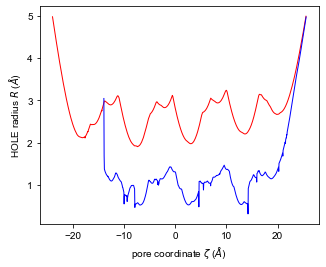

In [9]:
closed_xray = HOLE("../../1-Trajectories/0-Parm_rst/closed6_dry_rot1.pdb", endrad=5,
                   sphpdb="./hole_open.sph", sample=0.1, cvect=[0,0,1], 
                   executable="/home/el14718/Software/hole2/exe/hole") 
closed_xray.run()
closed_xray.collect()
closed_xray.create_vmd_surface(filename='hole_closed_xray.vmd')


fig, ax = plt.subplots(figsize=(5,4))
ax = open_xray.plot(linewidth=1, color="red", label=False)
ax = closed_xray.plot(linewidth=1, color="blue", label=False)

# ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
# ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

# ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

# ax.set_xticks(np.arange(0, 5, 0.5))
# ax.set_yticks(np.arange(0, 5, 0.5))

# fig.savefig('./plots/1-With_IPA/2_initial_FES.png', dpi=600)

In [11]:
clust1 = mda.Universe('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../5-sampled_cluster_trajectories/sample_cluster1.xtc')
H_clust1 = HOLEtraj(clust1 , step=1, endrad=5, sample=0.1, cvect=[0,0,1], \
             executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
H_clust1.run()

AttributeError: 'HOLEtraj' object has no attribute 'collect'

[(0.0, 4.5), (-30.0, 30.0)]

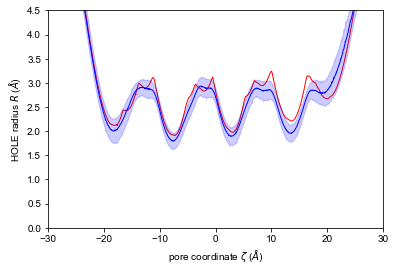

In [14]:
rxncoord_clust1 = np.concatenate([profile.rxncoord for frame, profile in H_clust1.sorted_profiles_iter()])
radii_clust1 = np.concatenate([profile.radius for frame, profile in H_clust1.sorted_profiles_iter()])

mean_r_clust1, q_clust1 = regularized_function(rxncoord_clust1, radii_clust1, np.mean, bins=1000)
std_r_clust1, q_clust1 = regularized_function(rxncoord_clust1, radii_clust1, np.std, bins=1000)
zeta_clust1 = 0.5*(q_clust1[1:] + q_clust1[:-1])

ax = plt.subplot(111)
ax.fill_between(zeta_clust1, mean_r_clust1 - std_r_clust1, 
                mean_r_clust1 + std_r_clust1, color="blue", alpha=0.2)
ax.plot(zeta_clust1, mean_r_clust1, color="blue", lw=1)
ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1, color='red', label=False)
ax.set(xlim=(-30, 30) , ylim=(0, 4.5))


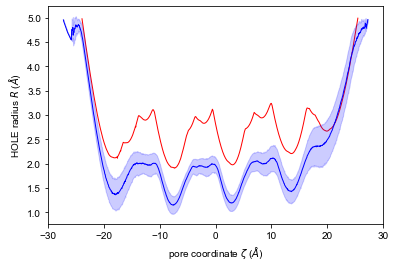

CPU times: user 50.5 s, sys: 1.46 s, total: 51.9 s
Wall time: 1min 51s


In [15]:
%%time

clust = mda.Universe('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../5-sampled_cluster_trajectories/sample_cluster2.xtc')
H_clust = HOLEtraj(clust , step=10, endrad=5, sample=0.1, cvect=[0,0,1], \
             executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
H_clust.run()

rxncoord_clust = np.concatenate([profile.rxncoord for frame, profile in H_clust.sorted_profiles_iter()])
radii_clust = np.concatenate([profile.radius for frame, profile in H_clust.sorted_profiles_iter()])

mean_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.mean, bins=1000)
std_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.std, bins=1000)
zeta_clust = 0.5*(q_clust[1:] + q_clust[:-1])

ax = plt.subplot(111)
ax.fill_between(zeta_clust, mean_r_clust - std_r_clust, 
                mean_r_clust + std_r_clust, color="blue", alpha=0.2)
ax.plot(zeta_clust, mean_r_clust, color="blue", lw=1)
ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1, color='red', label=False)
# ax.set(xlim=(-30, 30) , ylim=(0, 4.5))
plt.show()

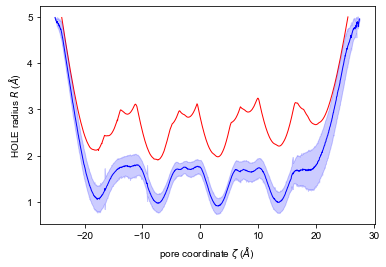

CPU times: user 26.3 s, sys: 748 ms, total: 27.1 s
Wall time: 59.2 s


In [16]:
%%time

clust = mda.Universe('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../5-sampled_cluster_trajectories/sample_cluster3.xtc')
H_clust = HOLEtraj(clust , step=10, endrad=5, sample=0.1, cvect=[0,0,1], \
             executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
H_clust.run()

rxncoord_clust = np.concatenate([profile.rxncoord for frame, profile in H_clust.sorted_profiles_iter()])
radii_clust = np.concatenate([profile.radius for frame, profile in H_clust.sorted_profiles_iter()])

mean_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.mean, bins=1000)
std_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.std, bins=1000)
zeta_clust = 0.5*(q_clust[1:] + q_clust[:-1])

ax = plt.subplot(111)
ax.fill_between(zeta_clust, mean_r_clust - std_r_clust, 
                mean_r_clust + std_r_clust, color="blue", alpha=0.2)
ax.plot(zeta_clust, mean_r_clust, color="blue", lw=1)
ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1, color='red', label=False)
# ax.set(xlim=(-30, 30) , ylim=(0, 4.5))
plt.show()

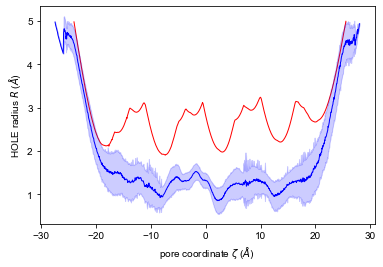

CPU times: user 38.1 s, sys: 1.04 s, total: 39.1 s
Wall time: 1min 15s


In [17]:
%%time

clust = mda.Universe('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../5-sampled_cluster_trajectories/sample_cluster4.xtc')
H_clust = HOLEtraj(clust , step=10, endrad=5, sample=0.1, cvect=[0,0,1], \
             executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
H_clust.run()

rxncoord_clust = np.concatenate([profile.rxncoord for frame, profile in H_clust.sorted_profiles_iter()])
radii_clust = np.concatenate([profile.radius for frame, profile in H_clust.sorted_profiles_iter()])

mean_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.mean, bins=1000)
std_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.std, bins=1000)
zeta_clust = 0.5*(q_clust[1:] + q_clust[:-1])

ax = plt.subplot(111)
ax.fill_between(zeta_clust, mean_r_clust - std_r_clust, 
                mean_r_clust + std_r_clust, color="blue", alpha=0.2)
ax.plot(zeta_clust, mean_r_clust, color="blue", lw=1)
ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");
ax = open_xray.plot(linewidth=1, color='red', label=False)
# ax.set(xlim=(-30, 30) , ylim=(0, 4.5))
plt.show()

In [25]:
def run_hole(top,traj,step):
    clust = mda.Universe(top, traj)
    
    H_clust = HOLEtraj(clust , step=step, endrad=5, sample=0.1, cvect=[0,0,1], \
                 executable="/home/el14718/Software/hole2/exe/hole")  # set path to your hole binary
    H_clust.run()

    rxncoord_clust = np.concatenate([profile.rxncoord for frame, profile in H_clust.sorted_profiles_iter()])
    radii_clust = np.concatenate([profile.radius for frame, profile in H_clust.sorted_profiles_iter()])

    mean_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.mean, bins=1000)
    std_r_clust, q_clust = regularized_function(rxncoord_clust, radii_clust, np.std, bins=1000)
    zeta_clust = 0.5*(q_clust[1:] + q_clust[:-1])
    
    return zeta_clust, mean_r_clust, std_r_clust

In [27]:
def plot_hole_result(zeta_clust, mean_r_clust, std_r_clust):
    ax = plt.subplot(111)
    ax.fill_between(zeta_clust, mean_r_clust - std_r_clust, 
                    mean_r_clust + std_r_clust, color="blue", alpha=0.2)
    ax.plot(zeta_clust, mean_r_clust, color="blue", lw=1)
    ax.set_xlabel(r"pore coordinate $\zeta$ ($\AA$)")
    ax.set_ylabel(r"HOLE radius $R$ ($\AA$)");
    ax = open_xray.plot(linewidth=1, color='red', label=False)
    ax.set(xlim=(-30, 30) , ylim=(0, 4.5))
    return ax

CPU times: user 3min 32s, sys: 6.36 s, total: 3min 39s
Wall time: 8min 17s


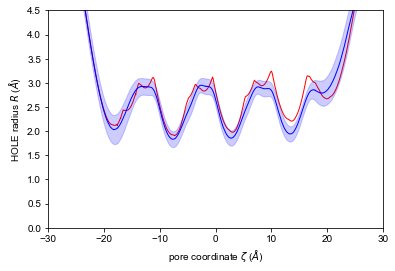

In [32]:
%%time

zeta_clust1, mean_r_clust1, std_r_clust1 = run_hole('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../4-full_cluster_trajectories/aligned_cluster1.xtc', 1)

plot_hole_result(zeta_clust1, mean_r_clust1, std_r_clust1)

CPU times: user 21.5 s, sys: 704 ms, total: 22.2 s
Wall time: 47.1 s


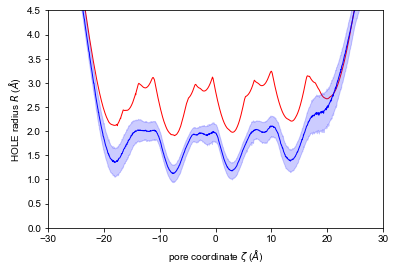

In [29]:
%%time

zeta_clust2, mean_r_clust2, std_r_clust2 = run_hole('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../4-full_cluster_trajectories/aligned_cluster2.xtc', 100)

plot_hole_result(zeta_clust2, mean_r_clust2, std_r_clust2)

CPU times: user 42.9 s, sys: 1.05 s, total: 43.9 s
Wall time: 1min 27s


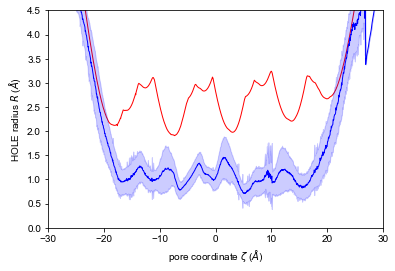

In [31]:
%%time

zeta_clust5, mean_r_clust5, std_r_clust5 = run_hole('../../1-Trajectories/0-Parm_rst/open10_dry.pdb', 
                    '../4-full_cluster_trajectories/aligned_cluster5.xtc', 10)

plot_hole_result(zeta_clust5, mean_r_clust5, std_r_clust5)